In [1]:
from snewpy.neutrino import Flavor
from snewpy.models import SupernovaModel

from astropy import units as u

from glob import glob

import h5py
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt

In [2]:
mpl.rc('font', size=16)

In [19]:
class Fornax2D(SupernovaModel):
    
    def __init__(self, filename):
        """Initialize model.

        Parameters
        ----------
        filename : str
            Absolute or relative path to FITS file with model data.
        """
        # Set up model metadata.
        self.progenitor_mass = float(filename.split('_')[-3][:-1]) * u.Msun
        
        # Conversion of flavor to key name in the model HDF5 file.
        self._flavorkeys = { Flavor.NU_E : 'nu0',
                             Flavor.NU_E_BAR : 'nu1',
                             Flavor.NU_X : 'nu2',
                             Flavor.NU_X_BAR : 'nu2' }
        
        # Open HDF5 data file.
        self._h5file = h5py.File(filename, 'r')
        
        # Get grid of model times.
        self.time = self._h5file['nu0'].attrs['time'] * u.s
        
        # Compute luminosity by integrating over model energy bins.
        self.luminosity = {}
        for flavor in Flavor:
            key = self._flavorkeys[flavor]
            dE = np.asarray(self._h5file[key]['degroup'])
            n = len(dE[0])
            dLdE = np.zeros((len(self.time), n), dtype=float)
            for i in range(n):
                dLdE[:,i] = self._h5file[key]["g{}".format(i)]
                
            # Note factor of 0.5 in nu_x and nu_x_bar.
            factor = 1e50*u.erg/u.s if flavor.is_electron else 0.5*1e50*u.erg/u.s
            self.luminosity[flavor] = np.sum(dLdE*dE, axis=1) * factor
        
    def get_time(self):
        return self.time
        
    def get_initialspectra(self, t, E):
        """Get neutrino spectra/luminosity curves after oscillation.

        Parameters
        ----------
        t : float
            Time to evaluate initial and oscillated spectra.
        E : float or ndarray
            Energies to evaluate the initial and oscillated spectra.

        Returns
        -------
        initialspectra : dict
            Dictionary of model spectra, keyed by neutrino flavor.
        """
        initialspectra = {}
        
        # Avoid "division by zero" in retrieval of the spectrum.
        E[E == 0] = np.finfo(float).eps * E.unit
        logE = np.log10(E.to('MeV').value)
        
        # Make sure the input time uses the same units as the model time grid.
        # Convert input time to a time index.
        t = t.to(self.time.unit)
        j = (np.abs(t - self.time)).argmin()
        
        for flavor in Flavor:
            key = self._flavorkeys[flavor]
            
            # Energy in units of MeV.
            _E = self._h5file[key]['egroup'][j]
            
            # Pad log(E) array with values where flux is fixed to zero.
            _logE = np.log10(_E)
            _dlogE = np.diff(_logE)
            _logEbins = np.insert(_logE, 0, np.log10(np.finfo(float).eps))
            _logEbins = np.append(_logEbins, _logE[-1] + _dlogE[-1])
            
            # Spectrum in units of 1e50 erg/s/MeV.
            # Pad with values where flux is fixed to zero.
            _dLdE = np.asarray([0.] + [self._h5file[key]['g{}'.format(i)][j] for i in range(12)] + [0.])

            # Linear interpolation in flux.
            factor = 1e50*u.MeV
            if not flavor.is_electron:
                # Model flavors (internally) are nu_e, nu_e_bar, and nu_x, which stands
                # for nu_mu(_bar) and nu_tau(_bar), making the flux 4x higher than nu_e and nu_e_bar.
                # Since we separate NU_X and NU_X_BAR here, multiply by 2x, not 4x.
                factor *= 0.5
            
            initialspectra[flavor] = np.interp(logE, _logEbins, _dLdE) * factor
            
        return initialspectra
    
    def __repr__(self):
        """Default representation of the model.
        """
        mod = 'Fornax 2D Model: {}\n'.format(self._h5file.filename)
        s = ['Progenitor mass : {}'.format(self.progenitor_mass)
            ]
        return mod + '\n'.join(s)

    def _repr_markdown_(self):
        """Markdown representation of the model, for Jupyter notebooks.
        """
        mod = '**Fornax 2D Model**: {}\n\n'.format(self._h5file.filename)
        s = ['|Parameter|Value|',
             '|:---------|:-----:|',
             '|Progenitor mass | ${0.value:g}$ {0.unit:latex}|'.format(self.progenitor_mass),
            ]
        return mod + '\n'.join(s)

In [20]:
model = Fornax2D('2d/lum_spec_12M_r10000_dat.h5')

In [22]:
model

**Fornax 2D Model**: 2d/lum_spec_12M_r10000_dat.h5

|Parameter|Value|
|:---------|:-----:|
|Progenitor mass | $12$ $\mathrm{M_{\odot}}$|

In [23]:
model.get_time()

<Quantity [-0.2135, -0.2125, -0.2115, ...,  4.4865,  4.4875,  4.4885] s>

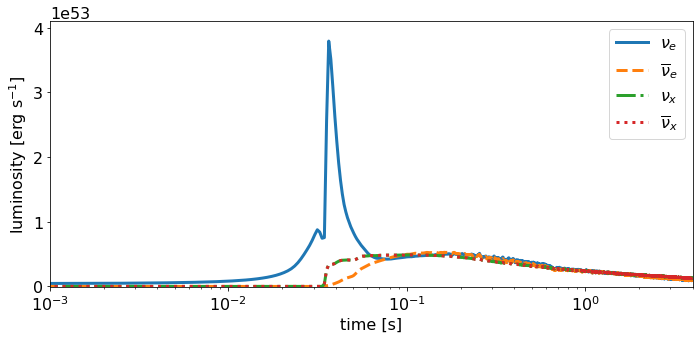

In [24]:
fig, ax = plt.subplots(1,1, figsize=(10,5), tight_layout=True)

linestyles = ['-', '--', '-.', ':']

for linestyle, flavor in zip(linestyles, Flavor):
    ax.plot(model.time, model.luminosity[flavor], lw=3, ls=linestyle, label=flavor.to_tex())

ax.set(xscale='log',
       xlim=(1e-3, 4),
       xlabel='time [s]',
       ylim=(-0.1e52, 4.1e53),
       ylabel='luminosity [erg s$^{-1}$]')
ax.legend();

In [25]:
np.arange(-0.2, 3.8, 0.2)

array([-0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ,  1.2,  1.4,  1.6,  1.8,
        2. ,  2.2,  2.4,  2.6,  2.8,  3. ,  3.2,  3.4,  3.6])

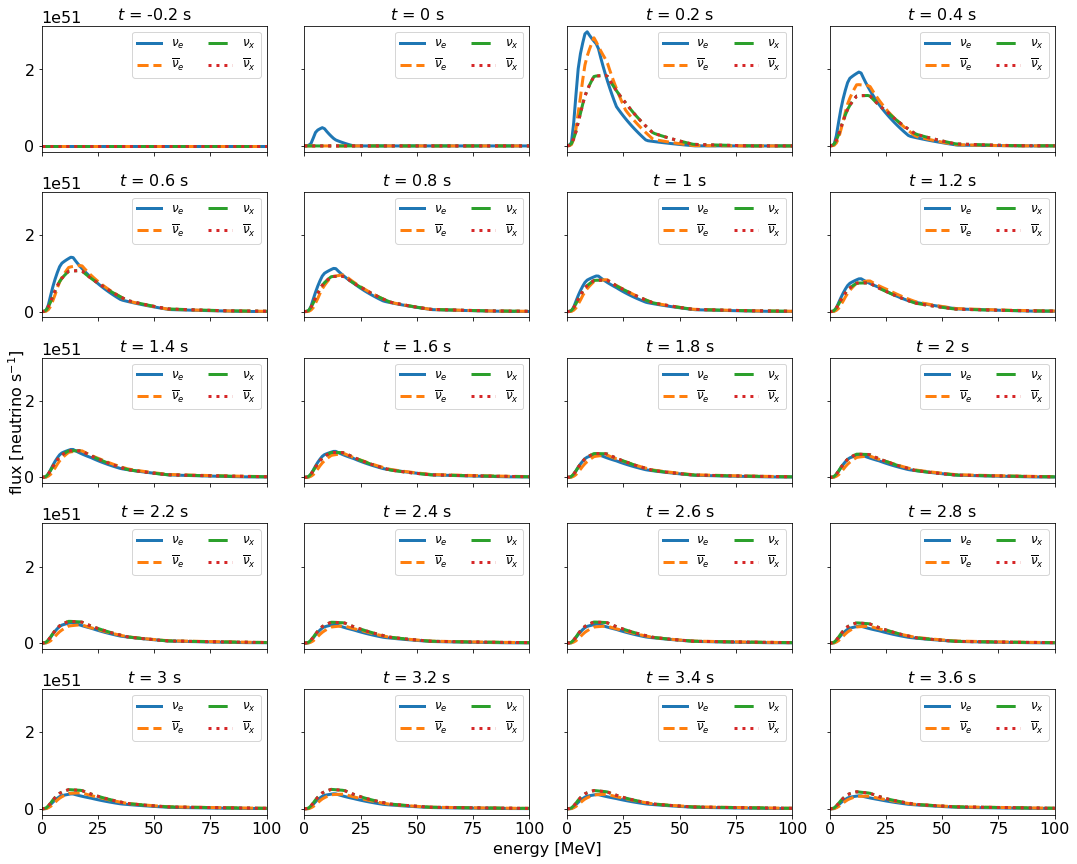

In [26]:
times = np.arange(-0.2, 3.8, 0.2) * u.s
E = np.arange(0, 101, 1) * u.MeV

fig, axes = plt.subplots(5,4, figsize=(15,12), sharex=True, sharey=True, tight_layout=True)

linestyles = ['-', '--', '-.', ':']

for t, ax in zip(times, axes.flatten()):
    spectra = model.get_initialspectra(t, E)
    for line, flavor in zip(linestyles, Flavor):
        ax.plot(E, spectra[flavor], lw=3, ls=line, label=flavor.to_tex())
    ax.set(xlim=(0,100))
    ax.set_title('$t$ = {:g}'.format(t), fontsize=16)
    ax.legend(loc='upper right', ncol=2, fontsize=12)

fig.text(0.5, 0., 'energy [MeV]', ha='center')
fig.text(0., 0.5, 'flux [neutrino s$^{-1}$]', va='center', rotation='vertical');

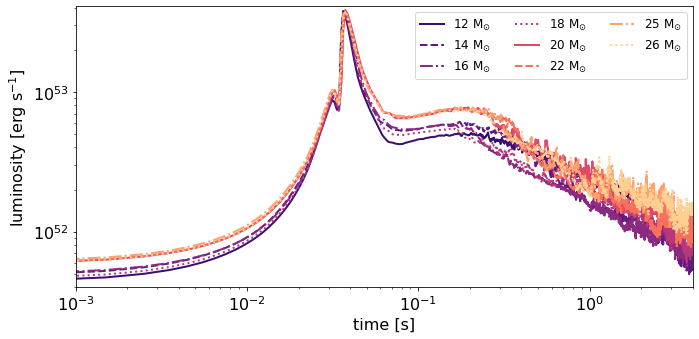

In [48]:
fig, ax = plt.subplots(1,1, figsize=(10,5), tight_layout=True)

flavor = Flavor.NU_E
files = sorted(glob('2d/lum*h5'))[::2]
colors = mpl.cm.magma(np.linspace(0.2,0.9, len(files)))
linestyles = ['-', '--', '-.', ':']

for i, file in enumerate(files):
    model = Fornax2D(file)
    ax.plot(model.time, model.luminosity[flavor], lw=2, color=colors[i], ls=linestyles[i%4],
            label='${0.value:g}$ {0.unit:latex}'.format(model.progenitor_mass))

ax.set(xscale='log',
       xlim=(1e-3, 4),
       xlabel='time [s]',
       yscale='log',
       ylim=(0.4e52, 4.1e53),
       ylabel='luminosity [erg s$^{-1}$]')

ax.legend(ncol=3, fontsize=12);